# **ABOUT DATASET**

iFood is the lead food delivery app in Brazil, present in over a thousand cities. Keeping a high customer engagement is key for growing and consolidating the company’s position as the market leader. Data Analysts working within the data team are constantly challenged to provide insights and value to the company through open scope projects. This case intends to simulate that. In this case, you are presented a sample dataset, that mocks metainformation on the customer and on iFood campaign interactions with that customer. It is your challenge to understand the data, find business opportunities & insights and to propose any data driven action to optimize the campaigns results & generate value to the company. This case aims to evaluate your Data skills and knowledge for two possible roles:

1. Data Analyst Business:

    - Perform robust exploratory analysis, rich with business insights & data driven proposals to add value to the company and have strong communication skills to influence the decision making.
    
2. Data Advanced Analytics:

    - Perform robust exploratory analysis, using advanced analytics tools and statistical methods to generate data products to optimize business results (predictive & clusterization models, for example).

## The Company

Consider a well-established company operating in the retail food sector. Presently they have around several hundred thousands of registered customers and serve almost one million consumers a year. They sell products from 5 major categories: wines, rare meat products, exotic fruits, specially prepared fish and sweet products. These can further be divided into gold and regular products. The customers can order and acquire products through 3 sales channels: physical stores, catalogs and company’s website. Globally, the company had solid revenues and a healthy bottom line in the past 3 years, but the profit growth perspectives for the next 3 years are not promising... For this reason, several strategic initiatives are being considered to invert this situation. One is to improve the performance of marketing activities, with a special focus on marketing campaigns.

## The Objective

The objective of the team is to build a predictive model that will produce the highest profit for the next direct marketing campaign, scheduled for the next month. The new campaign, sixth, aims at selling a new gadget to the Customer Database. To build the model, a pilot campaign involving
2.240 customers was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled. The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. Globally the campaign had a profit of -3.046MU. The success rate of the campaign was 15%. The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base. Hopefully the model will allow the company to cherry pick the customers that are most likely to purchase the offer while leaving out the non-respondents, making the next campaign highly profitable. Moreover, other than maximizing the profit of the campaign, the CMO is interested in understanding to study the characteristic features of those customers who are willing to buy the gadget.


In a nutshell, the key objectives are:

1. Explore the data – don’t just plot means and counts. Provide insights, define cause and effect. Provide a better understanding of the characteristic features of respondents;

2. Propose and describe a customer segmentation based on customers behaviors;

3. Create a predictive model which allows the company to maximize the profit of the next marketing campaign.

In [1]:
from sklearn.metrics import (auc,
                             roc_curve,
                             roc_auc_score, 
                             RocCurveDisplay,
                             silhouette_score,
                             confusion_matrix, 
                             classification_report,
                             PrecisionRecallDisplay,
                             precision_recall_curve,)
        
from sklearn.model_selection import (cross_val_score,
                                     StratifiedKFold,
                                     validation_curve,
                                     train_test_split, )

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np


# **EXPLORING THE DATA**

A look at the dataset indicates a total of 2240 customers with 29 features collected for the categorization of iFood's customers.

In [2]:
date_cols = ['Year_Birth', 'Dt_Customer']
ifood = pd.read_csv('marketing_campaign.csv',
                    delimiter=';',
                    parse_dates=date_cols)

print('customers: ', ifood['ID'].nunique())

print('features: ', ifood.shape[1], '\n')

displ_cols = ['ID', 'Education', 'Income', 'Recency', 'Response']
ifood[displ_cols].head()

customers:  2240
features:  29 



,ID,Education,Income,Recency,Response
0,5524,Graduation,58138.0,58,1
1,2174,Graduation,46344.0,38,0
2,4141,Graduation,71613.0,26,0
3,6182,Graduation,26646.0,26,0
4,5324,PhD,58293.0,94,0


## Handling Missing Data

Previously, it was confirmed that there are no duplicate entries. However, there are 24 missing entries for the yearly household `'Income'` feature.

In [3]:
mis_ftrs = ifood.isna().sum()>1
print(ifood.isna().sum()[mis_ftrs])

Income    24
dtype: int64


Being that median is less bias than the average, it will be used for filling in the missing values. The criteria being that the median income is based on the education level. Nonetheless, the decision to use median to fill missing values does not imply that it will be the statistics that will be used henceforth. 

In [4]:
ifood['Income'] = (ifood['Income']
                   .fillna(ifood.groupby(['Education'])
                           ['Income']
                           .transform('median')))
print()
print('missing income entries: ', ifood['Income'].isna().sum())


missing income entries:  0


## Superfluous Features

The `'Z_CostContact'` and `'Z_Revenue'` features have only one value for all the customers. Therefore, they are unnecessary for further analysis.

In [5]:
redun_ftrs = ifood.nunique()[ifood.nunique() < 2]
ifood = ifood.drop(list(redun_ftrs.keys()), axis=1)
redun_ftrs

Z_CostContact    1
Z_Revenue        1
dtype: int64

The `'Year_Birth'` feature is useful when calculating the ages of the customers. However, the feature becomes redundant once the calculation is done so it is removed from the data. Before calculating the age of each customer, it is important that we look at the time line for the study. A look at the data shows that the data was collected between 2012-07-30 to 2014-06-29. This means that any calculation involving dates will be based on this time line.

In [6]:
ifood['Dt_Customer'].agg(['min', 'max'])

min   2012-07-30
max   2014-06-29
Name: Dt_Customer, dtype: datetime64[ns]

With this information, the `'Age'` feature is created while the `'Year_Birth'` feature is removed. As we can see that the average age of these customers is 45 years with the youngest customer being 18 years while the oldest is 121.

In [7]:
now = ifood['Dt_Customer'].max().year

ifood['Age'] = now - ifood['Year_Birth'].dt.year 
ifood = ifood.drop('Year_Birth', axis=1)
ifood['Age'].agg(['mean', 'min', 'max']).round(0)

mean     45.0
min      18.0
max     121.0
Name: Age, dtype: float64

A closer look reveals that there are only three customers who are over 75 years; in fact, they are over 100 years. Despite the old age, my assumption is that these customers are being assisted by their loved ones when it comes to purchases iFood products.

In [8]:
ifood[['Age']][ifood['Age']>73]

,Age
192,114
239,121
339,115
1950,74


After these feature engineering, let's dive into exploratory data analysis. Note that more features will be created as need arise. In the next section, the goal will be to perform customer segmentation based on demographics, behavioral analytics and machine learning. Keep in mind that the success rate of the campaign was 15%.

# **DEMOGRAPHIC CUSTOMER SEGMENTATION**

One way organizations use to divide the market into distinct subgroups is by the use of demographic data. These data include factors like age, gender, education, income, e.t.c and they aid businesses in comprehending their clientele so that their requirements can be better met. In the next few sections, we'll have a look at success rate based on these demographics. Before diving deep, a `conversion_rate()` function is defined which will calculate the conversion/success rates based on the provided demographics.

In [9]:
def conversion_rate(variable, df):
    """Function to calculate the conversion rate"""
    conv_users = df.groupby(variable)['Response'].sum()
    total_users = df[variable].value_counts()
    conversion_rate = round((conv_users/total_users)*100,0)
    return conversion_rate

Another function that will be useful is the `explain_plot()`. This function is used to plot a scatterplot that provides more insight on the feature that is being examined given that another factor is considered.

In [10]:
def explain_plot(df, x, y):
    sns.scatterplot(x=x, 
                    y=y, 
                    hue=df.index, 
                    s=80, 
                    data=df)
    plt.axvline(x=15, color='#f67e6d', linestyle='--', 
                label="Overall Campaign's Success Rate")

## Education Level

How did education contribute to the success rate? Well, customers with PhD had a high success rate (21% against the overall 15%) while those with basic education had the poorest conversion rate (4% against the overall 15%). What could be the reason? Additionally, customers with Master (15%) and/or PhD (21%) were the ones who attained or were above the campaign success rate of 15%. The rest were below the success rate: Basic (4%), 2n Cycle (11%), and Graduation (13%).

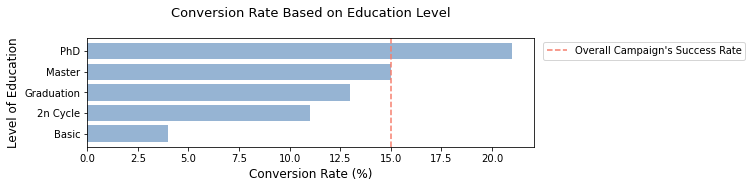

In [11]:
plt.figure(figsize=(8, 2))
edu_conv_rate = (conversion_rate('Education', df=ifood)
                 .sort_values())

plt.barh(edu_conv_rate.index, 
        edu_conv_rate, 
        color='#2f6aa8', 
        alpha=0.5)
plt.axvline(x=15, color='#f67e6d', linestyle='--',
            label="Overall Campaign's Success Rate")

plt.legend(loc=(1.02, 0.8))
plt.ylabel('Level of Education', size=12)
plt.xlabel('Conversion Rate (%)', size=12)
plt.title('Conversion Rate Based on Education Level\n', size=13);

### The Number Effect

One of the reason that comes to mind is the frequency of customers in the `'Education'` feature. A quick check shows that an assumption can be made that the low conversion rate within the group of customers with Basic and 2n Cycle education could be due to their low frequency in the data; (*N*=54) and (*N*=203) respectively. However, similar conclusions cannot be made when it comes to the other education groups. Additionally, it is evident that those who did not accept iFood products were more than those who did across all the level of education.

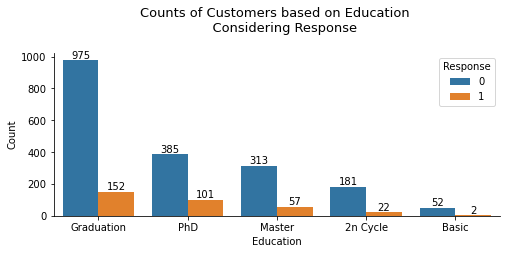

In [12]:
def count_response_ftrs(df, ftr):
    """Creates a df with the count of feature of 
    interest based on the Response. Thereafter, 
    plots the data."""
    
    ftr_freq = (df.groupby('Response')[ftr]
             .value_counts().to_frame())

    ftr_freq1 = (ftr_freq.rename(columns={ftr: 'Count'})
                  .reset_index())

    plt.figure(figsize=(8, 3))
    ax=sns.barplot(x=ftr, 
                   y='Count', 
                   hue='Response', 
                   data=ftr_freq1)

    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.title(f"""Counts of Customers based on {ftr} 
    Considering Response\n""".format(ftr), size=13)
    sns.despine();
    
count_response_ftrs(ifood, 'Education')

### The Income Effect

Another reason could be to examine the average household income based on these education groups. As compared to the previous results, household `'Income'` shows a positive relationship; that is, as the level of education goes up, income also goes up and this explains the cause of the increase in conversion rate. This trend may imply that after accounting for customer's income when grouping customer's based on their education status, higher level of education could mean more income which then could translate to more success rate of iFood products. 

**Heads up:** To interpret the plot and similar subsequent plots, the dotted orange line is the cut-off point of the campaign's success rate. Therefore, the values to the left fall below the campaign's success rate while those to the right fall above the campaign's success rate.

Anyway, it is interesting to note that there is no huge difference in average income between customers who have graduated vs those with masters. We can see that with a difference of just \\$177, customers with Master were within the campaign's success rate while those who had graduated were at 13\%. What if this small difference in income is what really determines the conversion rate? Perhaps, this makes sense because it is evident that those who accepted offers in this campaign had higher income compared to those who did not in virtually all the education level.

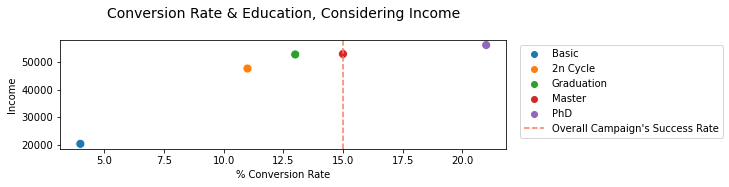

In [13]:
plt.figure(figsize=(8, 2))
income_education = (ifood.groupby('Education')
                    ['Income'].mean())

education_income = (pd.concat([income_education, 
                               edu_conv_rate], 
                              axis=1)
                    .sort_values(0)
                    .rename(columns={0: '% Conversion Rate'}))

explain_plot(education_income, 
             x='% Conversion Rate', 
             y='Income')
plt.title("Conversion Rate & Education, Considering Income\n", 
          size=14)

plt.legend(loc=(1.03, 0.1));

A check on the distribution of income depending within the education levels reveals that customers who accepted the campaigns offer had a high median income than those who did not.

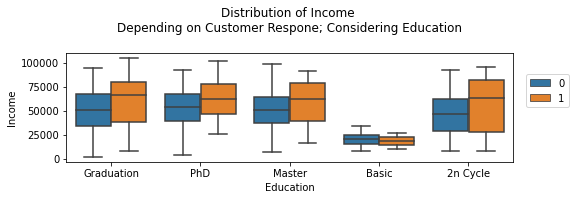

In [14]:
plt.figure(figsize=(8, 2))
plt.title("""Distribution of Income 
Depending on Customer Respone; Considering Education\n""")

sns.boxplot(x='Education', 
            y='Income', 
            hue='Response',
            orient='v', 
            sym='',
            data=ifood)
plt.legend(loc=(1.03, 0.5));

## Marital Status

The next demographic of interest is the marital status of the customers. Evidently, customers who consider themselves as YOLO or Absurd have the highest conversion rate (50% against the campaign's 15%). Additionally, those who consider themselves as Alone, Widow, Single, or Divorced have conversion rates higher than that recorded in the campaign; 33%, 25%, 22%, and 21% respectively. The groups that falls short of the campaign's success rate are those who are married (11%) or together (10%). What could be a good explanation to these success rate values?

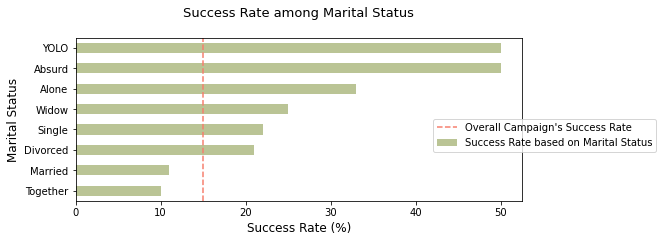

In [15]:
plt.figure(figsize=(8, 3))

marital_conv_rate = conversion_rate('Marital_Status', ifood)

(marital_conv_rate
 .sort_values()
 .plot(kind='barh', 
       color='#8c9d4f', 
       alpha=0.6, 
       label='Success Rate based on Marital Status'))

plt.axvline(x=15, color='#f67e6d', linestyle='--',
            label="Overall Campaign's Success Rate")

plt.legend(loc=(0.8, 0.3))
plt.ylabel('Marital Status', size=12)
plt.xlabel('Success Rate (%)', size=12)
plt.title('Success Rate among Marital Status\n', size=13);

### The Effect of Numbers

Just like we did when analyzing education level, here we'll also check the frequency of participants in each marital status category. Let's divide the results from this analysis into three parts:

1. The first part looks at the results from the YOLO, Absurd and Alone categories. YOLO and Absurd categories each has two customers with 50% conversion rate. In other words, one customer was converted while the other was not. Somehow, a similar situation is observed in the Alone category. With only three customers in this group, a 33% conversion rate means that only one out of three customers in this category purchased products in this campaign. With the low number of participants in this groups and the high conversion rates, the result are really promising but misleading. I would suggest that these categories be merged with a related category to avoid the promising yet misleading results.

2. The second part looks at the results from the Divorced, Single, and Widow categories. As discussed before, the categories in this second part provided a really promising conversion rate as compared to what was gotten from the campaign. Additionally, the number of customers in each group is reasonable; that is, the widow category has 77 customers, the divorced group has 232 participants, and the Single group has 480 customers. 

3. The final part looks at the results from the Together and Married group. As can be seen, these groups have the over 500 participants and the lowest conversion rate compared to the overall campaign's success rate. 

In general, we can conclude that as the number of participants decreases, the conversion rate goes up with an exception witnessed in the Single's category where the number of customers in the this group is more and the conversion rate is high. However, caution should be taken when interpreting this data because we've seen how misleading it can be.

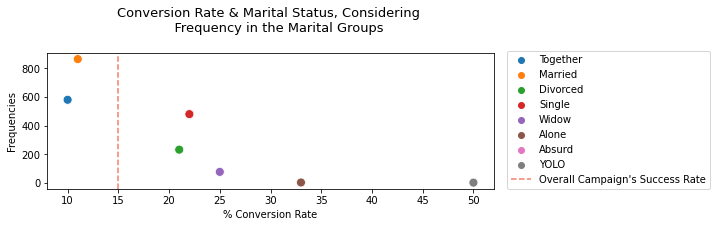

In [16]:
plt.figure(figsize=(8, 2.5))

marital_count = ifood['Marital_Status'].value_counts()

marital_conv_frq = (pd.concat([marital_count, marital_conv_rate],
                              axis=1).rename(columns={
                                  'Marital_Status': 'Frequencies',
                                  0: '% Conversion Rate'
                              }).sort_values('% Conversion Rate'))

explain_plot(marital_conv_frq, x='% Conversion Rate', y='Frequencies')
plt.legend(loc=(1.03, 0))
plt.title("""Conversion Rate & Marital Status, Considering 
    Frequency in the Marital Groups\n""",
    size=13);

The worrying thing is that the number of customers who do not accept the offers from this campaign is high compared to those who accept across all the marital levels. 

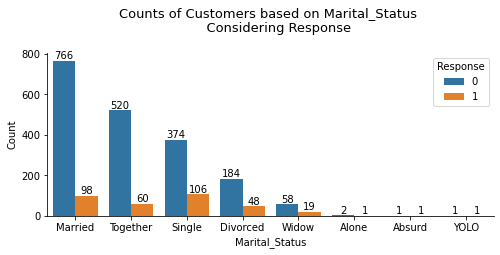

In [17]:
count_response_ftrs(ifood, 'Marital_Status')

### The Dependants Effect

Another explanation that can be explain the success rate in marital status is the number of dependants. 
Anyway, before we jump in to the nitty-gritty let's create a new feature called `'Dependants'` which is the summation of the features `'Kidhome'` and `'Tenhome'`. Being that the created feature will not be used when building a predictive model, we'll have to use a copy of `ifood` dataset.

In [18]:
copy_ifood = ifood.copy()

copy_ifood['Dependants'] = copy_ifood['Kidhome'] + copy_ifood['Teenhome']
copy_ifood[['Kidhome', 'Teenhome', 'Dependants']].head(3)

,Kidhome,Teenhome,Dependants
0,0,0,0
1,1,1,2
2,0,0,0


Next we compute the average of the number of dependants in each marital group. The results shows that basically all the marital groups have an average of one dependant, except for the Absurd category where there are no dependants and the Alone category which has an average of two dependants. Therefore, the average number of dependants does not really explain much about conversion rate within the marital status feature. Also keep in mind that the low number of customers within the Alone, Absurd, and YOLO groups give misleading results.

In [19]:
dependant_count = (copy_ifood
                   .groupby('Marital_Status')
                   ['Dependants']
                   .sum())

dep_conv = (pd.concat([dependant_count, marital_conv_rate],
                      axis=1)
            .rename(columns={0: '% Conversion Rate',
                             'Dependants': 'Frequencies'})
            .sort_values('% Conversion Rate'))

(dep_conv['Frequencies']/marital_count).round(0)

Absurd      0.0
Alone       2.0
Divorced    1.0
Married     1.0
Single      1.0
Together    1.0
Widow       1.0
YOLO        1.0
dtype: float64

### The Income Effect

The final factor we'll consider when interpreting the conversion rates in marital status is the effect of income. And as can be seen from the results, income does not clearly explains the success rate within the marital status categories because the result are somewhat random.

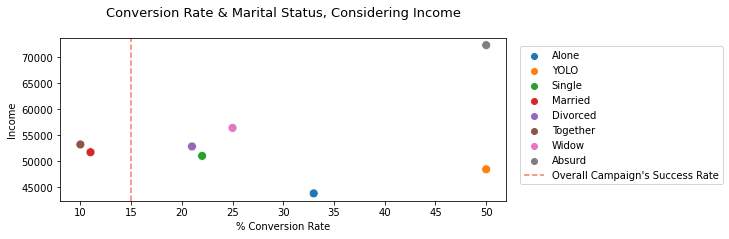

In [20]:
plt.figure(figsize=(8, 3))

inc_marital = ifood.groupby('Marital_Status')['Income'].mean()
inc_marital_conv = (pd.concat([inc_marital, marital_conv_rate], 
                              axis=1)
                    .rename(columns={0: '% Conversion Rate'})
                    .sort_values('Income'))

explain_plot(inc_marital_conv, x='% Conversion Rate', y='Income')
plt.legend(loc=(1.03, 0.1))
plt.title("Conversion Rate & Marital Status, Considering Income\n", 
          size=13);

## Age Group

Another feature of interest is age. However, before diving deep, let's create four categories of the age feature to allow for ease in analysis and interpretation. These categories are 15 years apart, that is `18-32`, `33-47`, `48-62`, and `63+`. Also, since we'll not be using them in creating a predictive model, we'll create them in the `copy_ifood` dataframe that was created earlier on.

In [21]:
bins= [18,33,48,63, np.inf]
labels = ['18-32','33-47','48-62','63+']

copy_ifood['Age_Group'] = pd.cut(copy_ifood['Age'], 
                                 bins=bins, 
                                 labels=labels, 
                                 right=False)
copy_ifood['Age_Group'].head(3)

0    48-62
1    48-62
2    48-62
Name: Age_Group, dtype: category
Categories (4, object): ['18-32' < '33-47' < '48-62' < '63+']

A quick check shows that majority of clients in this campaign were aged between 33-47 (*N*=984) followed by 48-62 (*N*=728) then those aged between 18-32 (*N*=346) while the minority were those aged 63+ (*N*=182). Here too we can see how poor success rate was. Customers within the age groups 18-32 and 63+ had conversion rates above the campaign's success rate;  21% and 16% respectively. Whereas, customers within the age brackets 33-47 and 48-62 had conversion rates below the one recorded in the campaign; 14% and 13% respectively. 

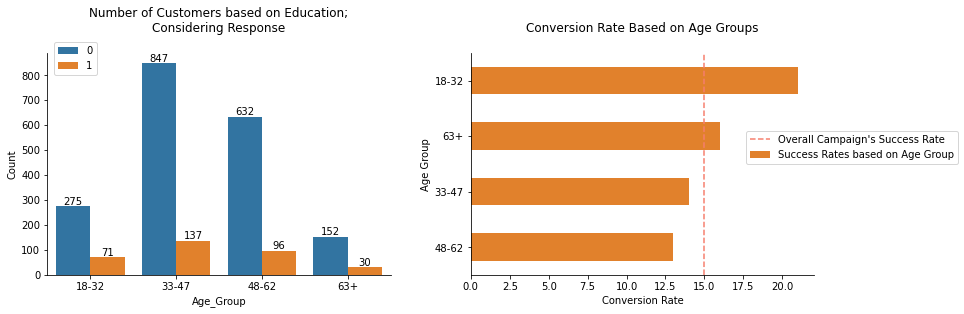

In [22]:
# Creating DF for age frequency plot
age_freq = (copy_ifood.groupby('Response')['Age_Group']
             .value_counts().to_frame().reset_index()
             .rename(columns={'level_1': 'Age_Group', 
                              'Age_Group': 'Count'}))

# Calculating conversion rate based on age
age_conv_rate = (conversion_rate('Age_Group', copy_ifood)
                 .sort_values())

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Age Frequency plot
ax=sns.barplot(x='Age_Group', 
               y='Count', 
               hue='Response', 
               data=age_freq, 
               ax=axs[0])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
axs[0].set_title("""Number of Customers based on Education;
Considering Response\n""")
axs[0].legend(loc=(0.02, 0.9))


# Conversion Rate Plot
age_conv_rate.plot(kind='barh', color='#e1812c', 
                   label='Success Rates based on Age Group', 
                   title='Conversion Rate Based on Age Groups\n')
plt.ylabel('Age Group')
plt.xlabel('Conversion Rate')
plt.axvline(x=15, color='#f67e6d', linestyle='--',
            label="Overall Campaign's Success Rate")
plt.legend(loc=(0.8, 0.5))
plt.tight_layout(pad=3)
sns.despine();

### The Income Effect 

To explain the conversion rate seen in these age groups we'll look at the income feature. A careful look at it is noticeable that as age increases the income also increases. However, the same cannot be said for conversion rate. We see that customers in age group 18-32 have the lowest average income yet they have the highest conversion rate of 21%. Interestingly, those in the age category 63+ have the highest income among the age groups and they have a conversion rate that is just a percent higher than the campaign's success rate. This result may mean that the company should focus products that target customers in 18-32 age group.

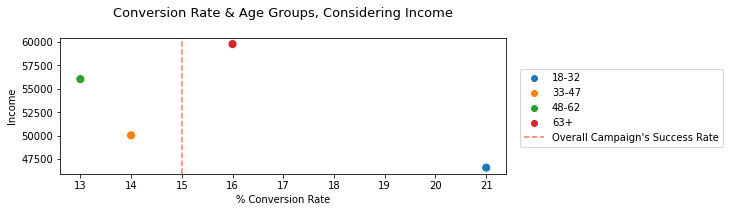

In [23]:
plt.figure(figsize=(8, 2.5))

inc_age = copy_ifood.groupby('Age_Group')['Income'].mean()

inc_age_conv = (pd.concat([inc_age, age_conv_rate], 
                              axis=1)
                    .rename(columns={0: '% Conversion Rate'})
                    .sort_values('% Conversion Rate'))

explain_plot(inc_age_conv, x='% Conversion Rate', y='Income')
plt.legend(loc=(1.03, 0.2))
plt.title("Conversion Rate & Age Groups, Considering Income\n", 
          size=13);

# **BEHAVIORAL CUSTOMER SEGMENTATION**

The term "behavioral segmentation" refers to a marketing technique where clients are divided into groups based on how they engage with a particular company or website. These segments could involve classifying clients according to their attitudes toward a product, brand, or service; their use of the product(s) or service(s); their general familiarity with the brand and its items; and, ultimately, their purchasing behaviors, such as only making purchases on special occasions like holidays or birthdays, etc. Let's dive into behavioral customer segmentation.

## Complains

The first behavior that we'll look at is from the `Complain` feature. From the analysis it is established that there were 21 customers who complained and and as a result 17 ended up rejecting products in the last campaign. Although twenty-one complaints may appear small, it seems that customer complaints should be addressed and if best, avoided.

In [24]:
complaints = (ifood[ifood['Complain'] == 1]
              [['Complain', 'Response']])

print('Number of Complaints: ', complaints['Complain'].sum())

print('Rejection Rate after Complaints: ', 
      str(round(100-(complaints['Response'].sum()/len(complaints))*100))+'%')

Number of Complaints:  21
Rejection Rate after Complaints:  86%


## Recency, Frequency, Monetary Value and Tenure (RFMT) 

The RFMT segmentation techniques that involves the calculation of four customer behavior metrics. Recency measures how recent was each customer's last purchase. Frequency measures how many purchases the customer has done during a particular period of time. Monetary reflects how much a customer has spent with the brand during a particular period of time. Tenure measures the number of days since first purchase order. Once we have calculated these numbers, we'll group them into some sort of categorization using the k-means clustering.

### Feature Engineering

To get started, we'll have to do some feature engineering using the `copy_ifood` dataframe. Here, we'll create the frequency and monetary value features only because the recency feature is already available. From the data provided all the features that deals with the amount of money spent has the string `'Mnt'` while those features that provides about frequency contain the string `'Purchases'`. Therefore, we'll use this knowledge to extract the necessary features.

In [25]:
monetary_cols = list(copy_ifood.filter(regex='Mnt').columns)
frequency_cols = list(copy_ifood.filter(regex='Purchases').columns)
tenure = (copy_ifood['Dt_Customer'].max() - 
          copy_ifood['Dt_Customer']).dt.days

print('Monetary Features: ', monetary_cols)
print()
print('Frequency Features: ', frequency_cols)

Monetary Features:  ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

Frequency Features:  ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']


From here we then create the RFM features by conducting summation within all the monetary features and frequency features. The monetary feature sums up the amount spent to purchase different products from the app. The frequency feature is the sum of all purchases made through discount, or catalog, or directly in the store, or through the website.

In [26]:
copy_ifood['MonetaryValue'] = (copy_ifood[monetary_cols]
                               .apply(np.sum,axis=1))

copy_ifood['Frequency'] = (copy_ifood[frequency_cols]
                                 .apply(np.sum, axis=1))

copy_ifood['Tenure'] = tenure

rfmt_cols = ['Recency', 'Frequency', 'MonetaryValue', 'Tenure']

rfmt_data = copy_ifood[['ID']+rfmt_cols].set_index('ID')
rfmt_data.head()

,Recency,Frequency,MonetaryValue,Tenure
ID,,,,
5524,58,25,1617,663
2174,38,6,27,113
4141,26,21,776,312
6182,26,8,53,139
5324,94,19,422,161


### Data Preprocessing

First let's review the underlying assumptions before exploring how we do consumer segmentation using K-means. First, a ll variables must all have symmetrical distributions. This implies that the distribution is not skewed. The second assumption is that the average values of all variables are the same. This is essential to ensuring that the k-means algorithm gives each metric the same weight. Finally, t he variance of each variable must then be scaled to the same levels. Similar to averages, it facilitates convergence of the algorithm and guarantees that each variable is given equal weight. As we can see, the Recency and Frequency metrics have symmetric distribution while MonetaryValue metrics has a tail on the right (right-skewed).

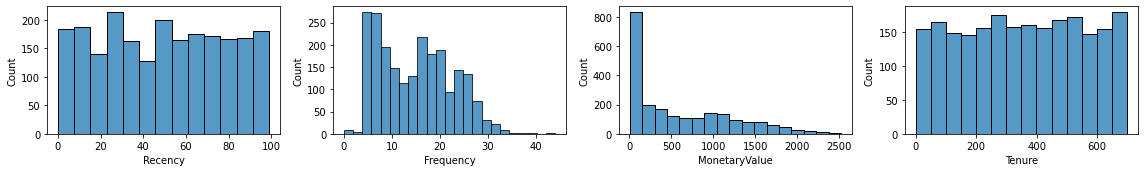

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(16, 2.5))

for i, var in enumerate(rfmt_data.columns):
        sns.histplot(x=var,ax=ax[i], data=rfmt_data)
plt.tight_layout()

For this case, a Box-Cox transformation was used instead of log-transformation because log-transformation gives a left-skew and it can be seen, the Monetary value assumed a symmetrical distribution.

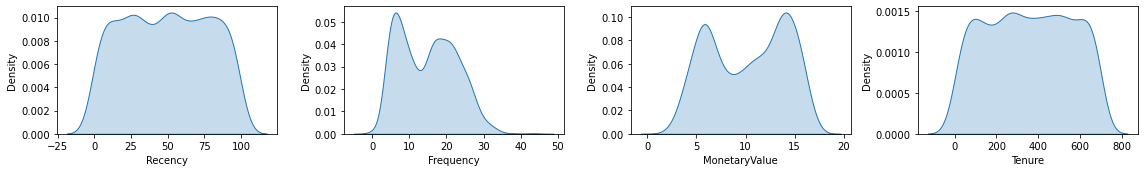

In [28]:
from scipy.stats import boxcox

boxcox_df = lambda x: boxcox(x)[0]

skew_var = ['MonetaryValue']
rfmt_data[skew_var] = rfmt_data[skew_var].apply(boxcox_df, axis=0)

fig, ax = plt.subplots(1, 4, figsize=(16, 2.5))

for i, var in enumerate(rfmt_data.columns):
        sns.kdeplot(x=var, ax=ax[i], data=rfmt_data, fill=True)
plt.tight_layout()



Here, we can observe that the three variables' mean scores and standard deviations differ from one another.

In [29]:
rfmt_data.describe().round(0).T

,count,mean,std,min,25%,50%,75%,max
Recency,2240.0,49.0,29.0,0.0,24.0,49.0,74.0,99.0
Frequency,2240.0,15.0,8.0,0.0,8.0,15.0,21.0,44.0
MonetaryValue,2240.0,10.0,4.0,2.0,6.0,11.0,14.0,17.0
Tenure,2240.0,354.0,202.0,0.0,181.0,356.0,529.0,699.0


Given that k-means works well on variables with the same mean values and the same variance, we will have to center and scale the data (normalize the data). Here is are the mean and standard deviation after the data is normalized.

In [30]:
scaler = StandardScaler()
rfmt_normalized = scaler.fit_transform(rfmt_data)
print('Normalized mean: ', np.mean(rfmt_normalized).round(0))
print('Normalized std: ', np.std(rfmt_normalized).round(0))

Normalized mean:  -0.0
Normalized std:  1.0


### Choosing Number of Clusters

To choose the number of clusters, the elbow criterion method is used to measure how well a clustering fit the data. The elbow criterion method plots the sum of squared errors for each segment count. Basically, the squared distances between each data point and the cluster center make up the sum of squared errors. The closer the individual points are to their respective clusters, the tighter the clusters, and the lower the SSE/inertia. The chart is then examined to determine the location where the SSE drop slows down and becomes relatively marginal. There are decreasing rewards as the number of clusters increases at that point, which resembles the elbow of a bent arm. According to the sum-of-squared errors, this point denotes the ideal number of clusters. In this case, the point with the largest angle (elbow) is at the second clusters.

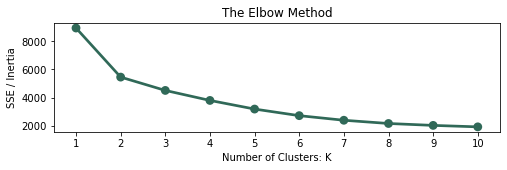

In [31]:
sse = {}

for k in range(1, 11):
    km_model = KMeans(n_clusters=k, random_state=123)
    km_model.fit(rfmt_normalized)
    sse[k] = km_model.inertia_

plt.figure(figsize=(8, 2))

sns.pointplot(x=list(sse.keys()), 
              y=list(sse.values()), 
              color='#306958')

plt.title('The Elbow Method')
plt.ylabel('SSE / Inertia')
plt.xlabel('Number of Clusters: K');



Also keep in mind that the clusters may not be actionable for one of two reasons: either they don't make commercial sense or there are much too many of them.

### Profiling and Interpretation of Segments

After determining an elbow or another computationally recommended number of segments, there is an experimental way to selecting the number of clusters that is optimal to utilize. In order to determine the approach that is most practical and insightful, we will compute the average RFM or other attribute values for each of these numbers. As an illustration, the elbow criteria plot for RFM data suggested two clusters; hence, we need at the very least create segmentation based on two and three clusters, and compare the results. Before we go any further, let's define a function that will provide summary statistics of the clusters by mean of each clusters. 

In [32]:
def rfmt_stats(k):
    """Creates summary statistic for the RFMT segments. 
    k is the number of clusters to explore its summary stats"""
    
    km_model = KMeans(n_clusters=k, random_state=123)
    km_model.fit(rfmt_normalized)
    rfmt_data_k = rfmt_data.assign(Cluster=km_model.labels_)
    
    return (rfmt_data_k.groupby(['Cluster'])
            .agg({'Recency': 'mean', 
                  'Frequency': 'mean',
                  'MonetaryValue': 'mean',
                  'Tenure': ['mean', 'count']})).round(0)

rfmt_stats

<function __main__.rfmt_stats(k)>

Another function that we'll define will create a snake plot: a chart that visualizes RFMT values between the segments. Note how the function transforms the normalized RFMT data before creating a snake plot. 

In [33]:
def snake_plot(k):
    """Transforms the normalized RFMT data to a df then
    create a melted df that is then visualized as a snake plot.
    
    `k` is the number of clusters to be visualized."""
    
    rfmt_normal= pd.DataFrame(rfmt_normalized, 
                                   index=rfmt_data.index, 
                                   columns=rfmt_data.columns)
    
    rfmt_normal['Cluster'] = (KMeans(n_clusters=k, random_state=123)
                              .fit(rfmt_normalized)
                              .labels_)
    
    rfmt_melt = pd.melt(rfmt_normal.reset_index(), 
                        id_vars=['ID', 'Cluster'], 
                        value_vars=rfmt_cols,
                        var_name='Attribute', 
                        value_name='Value')
    
    plt.figure(figsize=(8, 2.5))
    
    sns.lineplot(x='Attribute', 
                 y='Value', 
                 hue='Cluster', 
                 data=rfmt_melt)
    plt.title('Snake Plot of Standardized Variables')
    plt.show()
    
snake_plot

<function __main__.snake_plot(k)>

The final function will calculate the relative importance of each cluster's attribute compared to the population average and then visualize the output as a heatmap. The function calculates the average RFMT values for each cluster, and also the average for the total population and finally divide the two and subtract 1 from the result.

In [34]:
def relative_importance(k):
    """Calculates the relative importance of 
    each cluster attribute compared to the population
    then plots a heatmap.
    
    `k` is the number of clusters used to determine 
    relative importance of segments."""
    
    rfmt_normal= pd.DataFrame(rfmt_normalized, 
                                   index=rfmt_data.index, 
                                   columns=rfmt_data.columns)
    
    rfmt_normal['Cluster'] = (KMeans(n_clusters=k, random_state=123)
                              .fit(rfmt_normalized)
                              .labels_)
    
    cluster_avg = rfmt_normal.groupby(['Cluster']).mean()
    population_avg = rfmt_data.mean()
    rel_imp = cluster_avg / population_avg - 1
    
    plt.figure(figsize=(10, 2))
    sns.heatmap(data=rel_imp, 
                annot=True, 
                fmt='.2f', 
                cmap='PuBuGn')
    plt.title('Relative Importance of Attributes')
    
relative_importance

<function __main__.relative_importance(k)>

#### Two Clusters

For the first analysis we'll check the summary statistics, the snake plot and the relative importance of  the segment attributes when we use two clusters. From the summary statistics result, we can see that the 2 segment solution tells us that majority of the customers (*N*=1235) are in the second cluster and these are the customers who have the most purchases (Frequency) with high spending habit (MonetaryValue) and longest tenure (Tenure).

In [35]:
rfmt_stats(2)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          49.0       8.0           6.0  308.0  1005
1          49.0      21.0          13.0  391.0  1235

Visually, the representation can be as seen here. One thing that these two groups of customers share is how recent was each customer's last purchase (Recency).

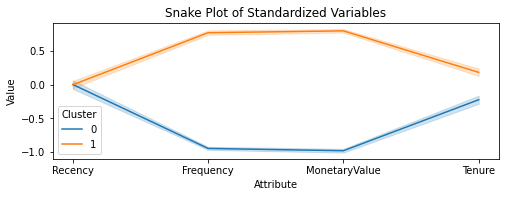

In [36]:
snake_plot(2)

In terms of relative importance, it is important to note that the further the RFMT average to population average ratio is from zero, the more important that attribute is for defining a specific cluster compared to the population average. Therefore, when using two clusters, the relative important feature in Cluster 0 is Monetary value while in Cluster 1 Recency and Tenure are the important feature.

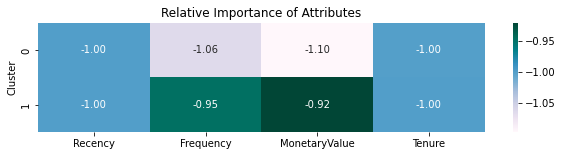

In [37]:
relative_importance(2)

#### Three Clusters

Let's look at how three clusters fits in our analysis before settling on which one to pick. From the summary statistics; 

- The majority of the existing customers (*N*=959) is in Cluster 0 which has the second-best average recency, the fewest purchases (Frequency), the lowest spending habits, and the shortest tenure.

- Cluster 1 is the second most populous group (*N*=672) with the worst average recency, and the longest tenure.

- Cluster 2 is the least populated group (*N*=609) but has the best average recency and the second longest tenure. 

- It is also evident that Cluster 1 and Cluster 2 have similar average Frequency and spending habits.

In [38]:
rfmt_stats(3)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          49.0       7.0           6.0  305.0   959
1          73.0      20.0          13.0  406.0   672
2          22.0      20.0          13.0  373.0   609

Visually, this information can be represented as shown below

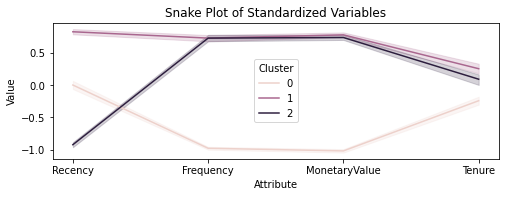

In [39]:
snake_plot(3)

When three clusters are considered, Monetary value is the important in Cluster 0, while Tenure is the important attribute for Cluster 1. For Cluster 2 Recency.

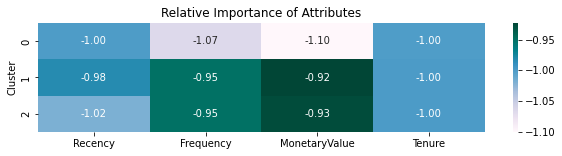

In [40]:
relative_importance(3)

### Evaluating the Clustering

The elbow approach with squared errors is somewhat quantitative but also depends on the user's judgment. Having in mind that no matter how statistically sound the clusters are, if the firm cannot act on them, they are meaningless, we'll have to ensure that we can be able to evaluate how good the result from clustering are. So let's utilize the silhouette score, which takes subjectivity out of the judgment but has the drawback of not being a particularly intuitive measure. It should be noted that the silhouette score is a generic measure of how well a clustering matches the data, therefore it may be used to evaluate not just two alternative models of various types, but also to determine hyperparameters such as the number of clusters. Here, we'll use it for the latter.

The silhouette score is made up of two major components. The first component determines how well a data point fits into the cluster to which it has been assigned. This is defined as the average distance between it and all other cluster members. The second component assesses how well the data point fits into the next closest cluster. It is determined in the same way by calculating the average distance between the data point and all of the data points assigned to the next closest cluster. The difference between these two values may be used to determine how well a data point fits into the cluster to which it is assigned as compared to another cluster. It therefore serves as a gauge of how well each data point fits into the specific cluster to which it has been assigned when calculated for all data points. The silhouette score is defined more precisely as follows: 

$$S(x_i) = \frac{bx_i - ax_i}{\text{max }(a_{xi}, b_{xi})}$$

Where  $xi$ is given data point, $a_{xi}$ is the average distance between that data point and all other data points in the same cluster and $b_{xi}$ is the average distance between data point $xi$ and the data points in the subsequent closest cluster. From the formula, we get a number between -1 and 1 when we divide by the maximum of $a_{xi}$ and $b_{xi}$. A negative score indicates that this data point is really closer to the other cluster on average, but a high positive score indicates that it is a much better fit to the cluster to which it is assigned. A number close to 0 indicates that the sample is near both clusters. When we average the scores over all data points, we still obtain a value between -1 and 1, with the closer we get to one, the better the match.

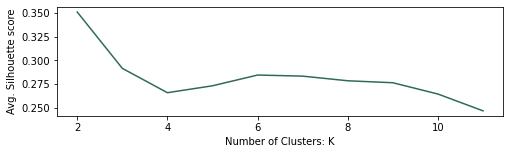

In [41]:
silhouette_avgs=[]

for k in range(2, 12):
    km_model = KMeans(n_clusters=k, random_state=123)
    clust_labels = km_model.fit_predict(rfmt_normalized)
    silhouette_avgs.append(silhouette_score(rfmt_normalized, 
                                            clust_labels))

plt.figure(figsize=(8, 2))

plt.plot(range(2, 12), silhouette_avgs, color='#306958')
plt.ylabel('Avg. Silhouette score')
plt.xlabel('Number of Clusters: K');

From the plot, we can infer that k=2 has the best silhouette score and is therefore the optimal number of clusters. This results conforms to the one we got from the elbow plot. However, based on the analysis, I would settle on using the three clusters in categorizing the customer because of the detail it brings from the analysis of attributes' relative importance. Further analysis shows that the success rate was high in Cluster 2 which is the least least populous group (*N*=609) but have the best average recency and the second longest tenure. Previously we saw that Cluster 2 and Cluster 1 had similar average Frequency and spending habits, therefore, the difference between the success rates between these clusters could be as a result of number of customers and tenure. Finally, the low success rate in Cluster 1 could be as a result of the fewest purchases, low spending habits and the shortes tenure.

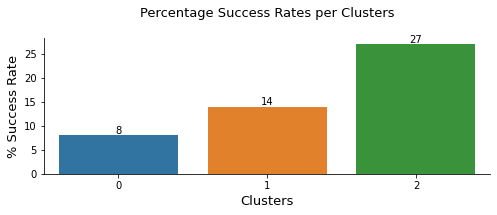

In [42]:
copy_ifood['Cluster'] = (KMeans(n_clusters=3, random_state=123)
                         .fit(rfmt_normalized).
                         labels_)

response_categ = copy_ifood.groupby('Cluster')['Response'].sum()
categ_num = copy_ifood.groupby('Cluster')['Response'].count()
cluster_rates = ((response_categ/categ_num)*100).round()

plt.figure(figsize=(8, 2.5))

ax = sns.barplot(y=cluster_rates.to_list(), 
                 x=[*cluster_rates.keys()])

ax.bar_label(ax.containers[0])
sns.despine()
plt.xlabel('Clusters', size=13)
plt.ylabel('% Success Rate', size=13)
plt.title('Percentage Success Rates per Clusters\n', size=13);

# **CREATING A PREDICTIVE MODEL**

The aim of this section is to create a predictive model which will allow the company to maximize the profit of the next marketing campaign. Before going any further, let's do some data preperation.

## Data Preprocessing

Let's start by first creating a `'Tenure'` feature from `'Dt_Customer'` and then dropping the `'Dt_Customer'` and `'ID'` features

In [43]:
ifood['Tenure'] = tenure
ifood = ifood.drop(['ID', 'Dt_Customer'], axis=1)
ifood.shape

(2240, 26)

The next step is to separate the feature and target variables and split them into a test and validation set. To account for any class imbalance, we'll use stratified splitting which ensures that we take into account the class distribution of the target feature while splitting the data into train and test sets. 

In [44]:
X = ifood.drop('Response', axis=1)
y = ifood['Response']

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=123)

X_train.shape, y_train.shape

((1568, 25), (1568,))

## Creating a Pipeline

Here we create a pipeline that apply different preprocessing and feature extraction pipelines to different subsets of features, using `ColumnTransformer()`. This is particularly handy for the case of datasets that contain heterogeneous data types, since we may want to scale the numeric features and binary encode the categorical ones. In this case, the numeric data is standard-scaled after median-imputation. The categorical data is binary encoded via `BinaryEncoder()`, which creates a new category for missing values. We create the preprocessing pipelines for both numeric and categorical data and store it in the variable `preprocessor`.

In [45]:
# Categorical features transformation
categ_ftrs = ['Education', 'Marital_Status']
categ_encoder = ce.BinaryEncoder(cols=categ_ftrs, return_df=False)

# Numerical features transformation
num_ftrs = [col for col in X.columns 
              if col not in categ_ftrs]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())])

# Categorical and Numerical preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_ftrs),
    ("cat", categ_encoder, categ_ftrs),])

Finally, we append a classifier to preprocessing pipeline in order to have a full prediction pipeline. Note that this will be done inside a `pipe_fit_score()` function. This function then outputs the confusion matrix, the classification report, and the roc_auc_score.

In [46]:
def pipe_fit_score(classifier):
    """Fits a pipeline then output the confusion matrix, 
    classification report and roc_auc_score."""
    
    ifood_pipe = Pipeline(steps=[("preprocessor", preprocessor), 
                                 ("classifier", classifier)])
    
    clf = ifood_pipe.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_pred_proba = clf.decision_function(X_val)
    
    print()
    print(pd.DataFrame(confusion_matrix(y_val, y_pred), 
                        columns=['Predicted: 0', 'Predicted: 1'], 
                        index=['Actual: 0', 'Actual: 1']))
    print('-'*50, '\n')
    print(classification_report(y_val, y_pred))
    print('-'*50)
    print('roc_auc_score: ', round(roc_auc_score(y_val, 
                                                 y_pred_proba), 2))
    
pipe_fit_score

<function __main__.pipe_fit_score(classifier)>

## Logistic Regression

The first model we'll use is the logistic regression. 

- The **precision** is 0.69 for those classified as accepting the campaign's offer; which is quite high. This means that not customers who did not accept the campaign's offers (0) were classified as accepting the offer (1). And from this case we can see that only 20 out of 65 customers were wrongly classified. Anyway, the average precision was 0.8. 

- The recall is 0.45 for those classified as accepting the campaign's offer. This means predicting most of those who accepted the campaign's offer correctly. In our case, the score is low because we can see that only 45 out of 90 customers were correctly classified. This highlights how poorly the model's recall is on the 1s class. The average recall is however high at 0.71.

- The F1-score (harmonic mean) for those who accepted this campaign's offer is 0.55 while the average F1-score is 0.74. However, the model's area under the curve is 0.92 which is higher that the average F1-score.

In [47]:
pipe_fit_score(LogisticRegression())


           Predicted: 0  Predicted: 1
Actual: 0           552            20
Actual: 1            55            45
-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       572
           1       0.69      0.45      0.55       100

    accuracy                           0.89       672
   macro avg       0.80      0.71      0.74       672
weighted avg       0.88      0.89      0.88       672

--------------------------------------------------
roc_auc_score:  0.92


The overall accuracy score is 0.92 but this does not tell us about the accuracies within each class. In particular, we are interested in the accuracy of class 1, which represents the customers who accept this campaign's offer. Therefore, we'll define a function `cross_val_class_score()`. In the function, we implement k-fold cross validation manually using `StratifiedKFold()` class. This class takes the number of folds as an initialization argument and provides the `.split()` method to build randomly sampled masks for the data. We use the indexes calculated from these masks to make a confusion matrix which we then use to calculate the accuracy scores for each fold. We return the list containing the accuracy scores as an array to allow for mathematical manipulations.

In [48]:
def cross_val_class_score(clf, X, y, cv=10):
    kfold = (StratifiedKFold(n_splits=cv, 
                             shuffle=True,
                             random_state=123).split(X, y))
    class_accuracy = []
    for k, (train, test) in enumerate(kfold):
        clf.fit(X.iloc[train], y.iloc[train])
        y_test2 = y.iloc[test]
        y_pred2 = clf.predict(X.iloc[test])
        
        cmat = confusion_matrix(y_test2, y_pred2)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy: {:s}'.format(k+1, 
                                                 str(class_acc)))
    return np.asarray(class_accuracy)

cross_val_class_score

<function __main__.cross_val_class_score(clf, X, y, cv=10)>

From the result it is evident how the accuracy scores of class 1 are low with an average of 0.47. We'll perform hyperparameter tuning to see if the accuracy scores in this class can be increased.

In [49]:
logreg = (Pipeline(steps=[("preprocessor", preprocessor), 
                         ("classifier", LogisticRegression())])
          .fit(X_train, y_train))

strat_scores = cross_val_class_score(logreg, X, y)
print()
print('Accuracy = {} +/- {}'\
      .format(strat_scores.mean(axis=0), 
              strat_scores.std(axis=0)))

fold: 1 accuracy: [0.97894737 0.44117647]
fold: 2 accuracy: [0.97894737 0.38235294]
fold: 3 accuracy: [0.94736842 0.47058824]
fold: 4 accuracy: [0.95263158 0.61764706]
fold: 5 accuracy: [0.97382199 0.63636364]
fold: 6 accuracy: [0.96335079 0.39393939]
fold: 7 accuracy: [0.95287958 0.51515152]
fold: 8 accuracy: [0.98429319 0.33333333]
fold: 9 accuracy: [0.97382199 0.45454545]
fold: 10 accuracy: [0.97382199 0.42424242]

Accuracy = [0.96798843 0.46693405] +/- [0.01232451 0.0931289 ]


### ROC Curve

Here we use a slight different method to plot the ROC curve but the concept remains the same. We can see that the ROC curve starts at (0,0) with a threshold high enough so that there are no positive classifications. We can see that when lowering the threshold to about 0.25, we get an increase in the TPR, but very little increase in the FPR. This means our classifier is doing a good job of correctly identifying positive samples. We can see the thresholds that lead to these rates by examining the threshold array, which is not part of the plot.

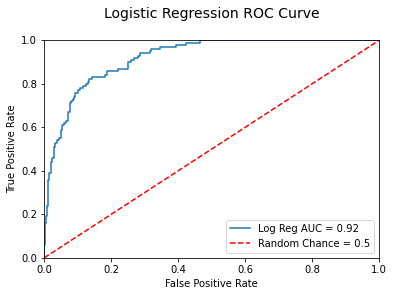

In [50]:
y_score = logreg.decision_function(X_val)
fpr, tpr, thresh = roc_curve(y_val, y_score, 
                             pos_label=logreg.classes_[1])

roc_display = (RocCurveDisplay(fpr=fpr, tpr=tpr)
               .plot(label='Log Reg AUC = %.02f'%(auc(fpr, tpr))))
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance = 0.5')
plt.title('Logistic Regression ROC Curve\n', size=14)
plt.legend()
plt.axis([0, 1, 0, 1]);

### Precision-Recall Curve

Precision and recall are often plotted together to assess the quality of positive predictions as far as what fraction are correct, while at the same time considering what fraction of the positive class a model is able to identify. Note that we put recall on the x-axis and precision on the y-axis, and we set the axes' limits to the range `[0, 1]`. Note that we also calculate the area under the precision-recall curve and use it as a legend.

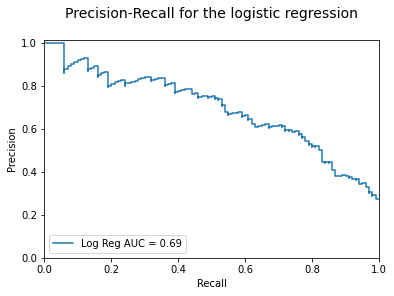

In [51]:
y_pred_proba = logreg.predict_proba(X_val)[:,1] 

log_prec, log_rec, _ = precision_recall_curve(y_val, 
                                              y_pred_proba)

(PrecisionRecallDisplay(precision=log_prec, 
                        recall=log_rec)
 .plot(label='Log Reg AUC = %0.2f'% (auc(log_rec, 
                                         log_prec))))

plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title('Precision-Recall for the logistic regression\n', 
          size=14);

### Did the Model Overfit

Here we compare training and test scores to determine whether the model overfit or underfit. And if so, will there be need to introduce some bias into the model training process in order to reduce overfitting and improves model performance on new, unseen data. We've specified `"l1"` (Lasso regularization) as the `'penalty'` argument. We've also set the `C` parameter to 1,000, indicating that we are not using much regularization here. Finally, we employ the `"liblinear"` `solver`. Because apart from `'saga'` it support the L1 penalty. From the computation, we get a score of 0.91 as the training and testing scores. It is thus, apparent that with less regularization the classifier performs equally, hence no overfitting.

In [52]:
(logreg.set_params(classifier__penalty='l1', 
                   classifier__C=1000, 
                   classifier__solver='liblinear')
 .fit(X_train, y_train))

y_train_pred_proba = logreg.predict_proba(X_train)
y_test_pred_proba = logreg.predict_proba(X_val)

print('Training score: ', round(roc_auc_score(y_train, 
                                              y_train_pred_proba[:,1]),2))
print('Testing score: ', round(roc_auc_score(y_val, 
                                             y_test_pred_proba[:,1]),2))

Training score:  0.91
Testing score:  0.91


Additionally, even after using less regularization, the accuracy of our model remains the same as what we got from the default parameters.

In [53]:
strat_scores = cross_val_class_score(logreg, X, y)
print()
print('Accuracy = {} +/- {}'\
      .format(strat_scores.mean(axis=0), 
              strat_scores.std(axis=0)))

fold: 1 accuracy: [0.97368421 0.44117647]
fold: 2 accuracy: [0.97894737 0.38235294]
fold: 3 accuracy: [0.94210526 0.47058824]
fold: 4 accuracy: [0.95263158 0.61764706]
fold: 5 accuracy: [0.95811518 0.63636364]
fold: 6 accuracy: [0.96335079 0.39393939]
fold: 7 accuracy: [0.95287958 0.51515152]
fold: 8 accuracy: [0.97905759 0.33333333]
fold: 9 accuracy: [0.97382199 0.45454545]
fold: 10 accuracy: [0.97382199 0.42424242]

Accuracy = [0.96484155 0.46693405] +/- [0.01223575 0.0931289 ]


Interestingly, increased regularization is introduced by lowering `C` to 0.01, the performance reduces and the training score is slightly lower than the testing score.

In [54]:
(logreg.set_params(classifier__penalty='l1', 
                   classifier__C=0.01, 
                   classifier__solver='liblinear')
 .fit(X_train, y_train))

y_train_pred_proba = logreg.predict_proba(X_train)
y_test_pred_proba = logreg.predict_proba(X_val)

print('Training score: ', round(roc_auc_score(y_train, 
                                              y_train_pred_proba[:,1]),2))
print('Testing score: ', round(roc_auc_score(y_val, 
                                             y_test_pred_proba[:,1]),2))

Training score:  0.83
Testing score:  0.85


Introducing regularization meant that the model performance best on the training data while giving poor results on unseen data (overfitting).

In [55]:
strat_scores = cross_val_class_score(logreg, X, y)
print()
print('Accuracy = {} +/- {}'\
      .format(strat_scores.mean(axis=0), 
              strat_scores.std(axis=0)))

fold: 1 accuracy: [1.         0.08823529]
fold: 2 accuracy: [1.         0.14705882]
fold: 3 accuracy: [0.98421053 0.14705882]
fold: 4 accuracy: [0.98947368 0.14705882]
fold: 5 accuracy: [1.         0.15151515]
fold: 6 accuracy: [0.9947644  0.09090909]
fold: 7 accuracy: [0.9947644  0.15151515]
fold: 8 accuracy: [1.         0.03030303]
fold: 9 accuracy: [0.9895288  0.12121212]
fold: 10 accuracy: [0.9947644  0.18181818]

Accuracy = [0.99475062 0.12566845] +/- [0.00525768 0.04193497]


### Hyperparameter Tuning



## Support Vector Classifier

In [56]:
pipe_fit_score(SVC(C=15))


           Predicted: 0  Predicted: 1
Actual: 0           543            29
Actual: 1            49            51
-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       572
           1       0.64      0.51      0.57       100

    accuracy                           0.88       672
   macro avg       0.78      0.73      0.75       672
weighted avg       0.88      0.88      0.88       672

--------------------------------------------------
roc_auc_score:  0.9
